# Capstone Project
**for IBM's Coursera Specialization [Applied Data Science](https://www.coursera.org/specializations/applied-data-science)**

----

This notebook will contain my capstone Data Science project in which I will analyze and visualize location data from Foursquare.

## Introduction
This Project aims to show a technique leverage geospatial data from the Foursquare API by a fictional Business Problem. This technique (and even this code) could be used anywhere without feeding it specific data and for any kind of venue.

### Busines Problem
Our client wants to open a new restaurant in Berlin. They want data-driven advice as to where and what kind of restaurant would be lucrative pick. This client already runs several restaurants in major european cities and have a business strategy in place which will dictate our basic methodology.

This strategy is relatively simple: Go to an area where you can be sure there will be lots of paying customers and offer something that is rare and unique in this place.

## Basic Methodology

Based on this strategy we state two presumptions:
 * __The more restaurants in the area the better__ \
   even though there will be high competition in these areas, it is proven that a restaurant can be profitable there
 * __The uniquer the kind of restaurant the better__ \
   to deal with high competition there should be something to set our clients restaurant apart from the rest of the market. \
   There is a constraint on that rule though: \
   There should be __at least a single instance__ of any suggested category so we have at least some proof that this kind of food can find buyers in this city but __the farer away the better__.

So this determines the goal of our analysis: __Identify areas that have lots of restaurants and find out what kinds of restaurants would be unique there__.

## Data
The specific locations of the areas to analyze will not come from an existing data since coordinates from existing units of Berlin (like Postal Code Areas, Administrative Districts, ...) are unevenly distributed over the city and have weird shapes. Instead I will calculate a matrix of points over a chosen area and analyze and compare the areas around them with each other.

The data about existing restaurants in these areas will come from the Foursquare API as required by the assignment. I will use the /venues/search endpoint and filter by "Food"-categories to get all restaurants in the area. I should end up with a grid of areas over the city (inlcuding Lattitude, Longitude and an Area ID) and a list of venues for each of them (the venue data to work with will be the _category_ from the Foursquare Database).

A big advantage of this approach is that it is not bound to any Berlin-specific data. Location and size of the analized area are variable and would work anywher (as long as Foursquare can deliver meaningful venue data for the chosen area).

### Missing Data
For an business assessment our client has to include costs of running the place and at this point rent would be the most important factor. If we had some data on average rent price for commercial property per m² for each area we could factor that in pretty easily. Unfortunatly I couldn't find data like that for free, if this was a real case and we had a budget we could buy this data.

## Data Analysis

In [9]:
# import libraries
import pandas as pd
import numpy as np
import folium
import matplotlib.pyplot as plt
import math
import requests
from geopy.distance import geodesic
from IPython.display import display_html
from io import BytesIO
import base64

To get coordinates I implemented an algorithm for shifting a point (lattitude, longitude) in meters ([Source](https://gis.stackexchange.com/a/2980)).

In [3]:
def displace_latlon(lat, lon, offset_north, offset_east):
    R=6378137 # Earth radius
    dLat = offset_north/R
    dLon = offset_east/(R*math.cos(math.pi*lat/180))
    return (lat + dLat * 180/math.pi , lon + dLon * 180/math.pi)

With this I was able to calculate matrix of coordinates.

In [5]:
def get_coord_matrix(start_lat, start_lon, rows, cols, radius):
    coords = []
    for row in range(rows):
        offset_east = 2 * radius * row * 0.7
        for col in range(cols):
            offset_north = 2 * radius * -col + row%2*radius
            coords.append(displace_latlon(start_lat, start_lon, offset_north, offset_east))
    return coords

Starting in the north east of the inner city I generate 10x10 points on the map with about 1 km between them. I chose 1 km because it's a convient distance to walk.

In [8]:
start_lat = 52.561008
start_lon = 13.333471
spot_radius = 500

spots = get_coord_matrix(start_lat, start_lon, 15, 10, spot_radius)

I plot these on a map to verify they cover the desired area.

In [10]:
mitte_lat = 52.5124156
mitte_lon = 13.3905563

# create map
berlin_map = folium.Map(location=[mitte_lat, mitte_lon], zoom_start=12)

# instantiate a feature group for the spots in the list
spot_features = folium.map.FeatureGroup()

# loop through the calculated spots and add each to the feature group
for spot in spots:
    spot_features.add_child(
        folium.features.Circle(
            spot,
            radius=spot_radius, # define how big you want the circle markers to be
            color='transparent',
            fill=True,
            fill_color='red',
            fill_opacity=0.5,
            popup=spot
        )
    )

# add incidents to map
berlin_map.add_child(spot_features)

# display the map
berlin_map

Looks pretty good. There is some overlap which can't be avoided since we are working with circles but it doesn't matter with the methods I have chosen. I'll put them into a dataframe, order them conveniently and get some venue data from the foursquare API for all of them.

In [12]:
df_spots = pd.DataFrame(spots, columns=['lat','lon'])
df_spots.sort_values(by=['lat','lon'], ascending=[False, True], inplace=True)
df_spots.reset_index(drop=True, inplace=True)
df_spots.reset_index(inplace=True)
df_spots.rename(columns={'index':'spot_id'}, inplace=True)
df_spots

,spot_id,lat,lon
0,0,52.56550,13.343815
1,1,52.56550,13.364503
2,2,52.56550,13.385190
3,3,52.56550,13.405878
4,4,52.56550,13.426566
...,...,...,...
145,145,52.48016,13.395534
146,146,52.48016,13.416222
147,147,52.48016,13.436910
148,148,52.48016,13.457597


### Getting Data from Foursquare

In [14]:
CLIENT_ID = 'YOURCLIENTID' # your Foursquare ID
CLIENT_SECRET = 'YOURSECRET' # your Foursquare Secret
ACCESS_TOKEN = 'YOURTOKEN' # your FourSquare Access Token
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [15]:
# construct the url for api call by coordinates
def get_api_url(lat, lon, radius):
    return "https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&categoryId={}&radius={}&limit={}".format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        lat, 
        lon, 
        ACCESS_TOKEN, 
        VERSION, 
        '4d4b7105d754a06374d81259', # category 'Food'
        radius, 
        LIMIT)

In [16]:
# filter the api responses for further use
def filter_response(response):
    try:
        venues = response['response']['venues']
    except:
        return pd.DataFrame()
    # transform venues into a dataframe
    dataframe = pd.json_normalize(venues)

    # keep only columns that include venue name, and anything that is associated with location
    filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
    dataframe_filtered = dataframe.loc[:, filtered_columns]

    # function that extracts the category of the venue
    def get_category_type(row):
        try:
            categories_list = row['categories']
        except:
            categories_list = row['venue.categories']

        if len(categories_list) == 0:
            return None
        else:
            return categories_list[0]['name']

    # filter the category for each row
    dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

    # clean column names by keeping only last term
    dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]
    
    # remove another unneeded column
    dataframe_filtered.drop(columns=['labeledLatLngs'], inplace=True)
    
    # some 'Food'-venues aren't restaurants, like cafés or covenience stores, lets remove these
    no_restaurant = ['Bagel Shop', 'Bakery', 'Bar', 'Bathing Area', 'Beach Bar', 'Beer Bar', 'Bike Shop', 'Bookstore', 'Breakfast Spot', 'Bubble Tea Shop', 'Butcher', 'Cafeteria', 'Café', 'Candy Store', 'Cheese Shop', 'Chocolate Shop', 'Cocktail Bar', 'Coffee Roaster', 'Coffee Shop', 'College Cafeteria', 'Convenience Store', 'Corporate Cafeteria', 'Corporate Coffee Shop', 'Coworking Space', 'Cupcake Shop', 'Design Studio', 'Dessert Shop', 'Donut Shop', 'Drugstore', 'Event Space', 'Farmers Market', 'Fish Market', 'Food', 'Food & Drink Shop', 'Food Truck', 'Frozen Yogurt Shop', 'Gas Station', 'Gay Bar', 'Gift Shop', 'Gourmet Shop', 'Grocery Store', 'Gym / Fitness Center', 'Historic Site', 'Hookah Bar', 'Hostel', 'Hotel Bar', 'Ice Cream Shop', 'Indie Movie Theater', 'Jazz Club', 'Juice Bar', 'Karaoke Bar', 'Laundry Service', 'Liquor Store', 'Market', 'Martial Arts School', 'Miscellaneous Shop', 'Organic Grocery', 'Other Nightlife', 'Pastry Shop', 'Pop-Up Shop', 'Salon / Barbershop', 'Shopping Mall', 'Smoothie Shop', 'Snack Place', 'Sports Bar', 'Supermarket', 'Tattoo Parlor', 'Tea Room', 'Theater', 'Restaurant', 'Deli / Bodega', 'Food Stand', 'Pub', 'Irish Pub', 'Pie Shop', 'Food Court', 'Hotel', 'Wine Bar', 'Wine Shop']
    dataframe_filtered = dataframe_filtered[~dataframe_filtered.categories.isin(no_restaurant)]
    
    dataframe_filtered.reset_index(drop=True, inplace=True)

    return dataframe_filtered

In the next step the venue data is fetched from Foursquare and filtered with the above function

In [17]:
spot_venues = []

for i, spot in df_spots.iterrows():
    print(f"get data for Spot {i} ({spot.lat}, {spot.lon})")
    url = get_api_url(spot.lat, spot.lon, spot_radius)
    result = requests.get(url).json()
    filtered_result = filter_response(result)
    filtered_result['spot_id'] = spot.spot_id
    filtered_result['spot_lat'] = spot.lat
    filtered_result['spot_lon'] = spot.lon
    spot_venues.append(filtered_result)
    
df_full = pd.concat(spot_venues)
df_full['spot_id'] = df_full['spot_id'].astype(int)
df_full.head()

get data for Spot 0 (52.5654995764206, 13.343814869195395)
get data for Spot 1 (52.5654995764206, 13.364502607586184)
get data for Spot 2 (52.5654995764206, 13.385190345976975)
get data for Spot 3 (52.5654995764206, 13.405878084367766)
get data for Spot 4 (52.5654995764206, 13.426565822758555)
get data for Spot 5 (52.5654995764206, 13.447253561149346)
get data for Spot 6 (52.5654995764206, 13.467941299540136)
get data for Spot 7 (52.561008, 13.333471)
get data for Spot 8 (52.561008, 13.35415873839079)
get data for Spot 9 (52.561008, 13.37484647678158)
get data for Spot 10 (52.561008, 13.39553421517237)
get data for Spot 11 (52.561008, 13.416221953563161)
get data for Spot 12 (52.561008, 13.43690969195395)
get data for Spot 13 (52.561008, 13.457597430344741)
get data for Spot 14 (52.561008, 13.478285168735532)
get data for Spot 15 (52.5565164235794, 13.343814869195395)
get data for Spot 16 (52.5565164235794, 13.364502607586184)
get data for Spot 17 (52.5565164235794, 13.385190345976975)

,name,categories,address,lat,lng,distance,postalCode,cc,city,state,country,formattedAddress,id,spot_id,spot_lat,spot_lon,crossStreet,neighborhood
0,Wok Asia imbiss,Vietnamese Restaurant,NaN,52.567853,13.346280,310,NaN,DE,Berlin,Berlin,Deutschland,"[Berlin, Deutschland]",560bea61498e52b9da87b535,0,52.5655,13.343815,NaN,NaN
0,Hamoudi‘S Snackstation,Doner Restaurant,NaN,52.565207,13.363339,85,NaN,DE,NaN,NaN,Deutschland,[Deutschland],5dcbd2b61158c90007f8f4ff,1,52.5655,13.364503,NaN,NaN
1,Irmak Grillhaus,Doner Restaurant,NaN,52.566548,13.362739,166,NaN,DE,Berlin,Berlin,Deutschland,"[Berlin, Deutschland]",5429411c498e82f0e3cdb850,1,52.5655,13.364503,NaN,NaN
2,Curry Eck,Diner,Residenzstr. 35,52.566791,13.362486,198,13409,DE,Berlin,Berlin,Deutschland,"[Residenzstr. 35, 13409 Berlin, Deutschland]",501a815fe4b08d4f17a214c2,1,52.5655,13.364503,NaN,NaN
3,Pizzeria Alte Forno,Pizza Place,NaN,52.563910,13.363988,180,NaN,DE,Berlin,Berlin,Deutschland,"[Berlin, Deutschland]",5343df45498ebeff7d7b6276,1,52.5655,13.364503,NaN,NaN


Get a first look at the venue categories:

In [18]:
df_full['categories'].describe()

count                   3130
unique                   116
top       Italian Restaurant
freq                     252
Name: categories, dtype: object

Let's list the Top 25 Categories to get some idea what the people of Berlin like to eat

In [20]:
df_full['categories'].value_counts().head(25)

Italian Restaurant               252
German Restaurant                208
Pizza Place                      207
Doner Restaurant                 185
Vietnamese Restaurant            178
Asian Restaurant                 159
Burger Joint                     133
Turkish Restaurant               119
Fast Food Restaurant             114
Indian Restaurant                 92
Bistro                            88
Falafel Restaurant                84
Middle Eastern Restaurant         73
Vegetarian / Vegan Restaurant     65
Chinese Restaurant                63
Gastropub                         50
Sushi Restaurant                  49
Thai Restaurant                   46
Diner                             43
Korean Restaurant                 39
French Restaurant                 39
Trattoria/Osteria                 39
Sandwich Place                    38
BBQ Joint                         36
Currywurst Joint                  33
Name: categories, dtype: int64

A list of every category could also be helpful for our client:

In [25]:
print(df_full['categories'].unique())

['Vietnamese Restaurant' 'Doner Restaurant' 'Diner' 'Pizza Place'
 'Asian Restaurant' 'Kebab Restaurant' 'Italian Restaurant'
 'Indian Restaurant' 'Chinese Restaurant' 'Turkish Restaurant' 'Bistro'
 'Eastern European Restaurant' 'Fast Food Restaurant' 'Buffet'
 'Halal Restaurant' 'BBQ Joint' 'Falafel Restaurant'
 'Middle Eastern Restaurant' 'Mexican Restaurant' 'Burger Joint'
 'Gastropub' 'Spanish Restaurant' 'Japanese Restaurant' 'Greek Restaurant'
 'German Restaurant' 'Tapas Restaurant' 'French Restaurant'
 'Currywurst Joint' 'Fried Chicken Joint' 'Seafood Restaurant'
 'Argentinian Restaurant' 'Mediterranean Restaurant' 'Brasserie'
 'Vegetarian / Vegan Restaurant' 'Sushi Restaurant' 'Steakhouse'
 'Trattoria/Osteria' 'Thai Restaurant' 'Gozleme Place' 'Burrito Place'
 'Pakistani Restaurant' 'Soup Place' 'Taverna' 'Bosnian Restaurant'
 'Syrian Restaurant' 'Korean Restaurant' 'Molecular Gastronomy Restaurant'
 'Pide Place' 'Yemeni Restaurant' 'African Restaurant'
 'Lebanese Restaurant' '

A visual representation of the former information would be even more helpful. I'm choosing a horizontal barchart here:

<AxesSubplot:ylabel='categories'>

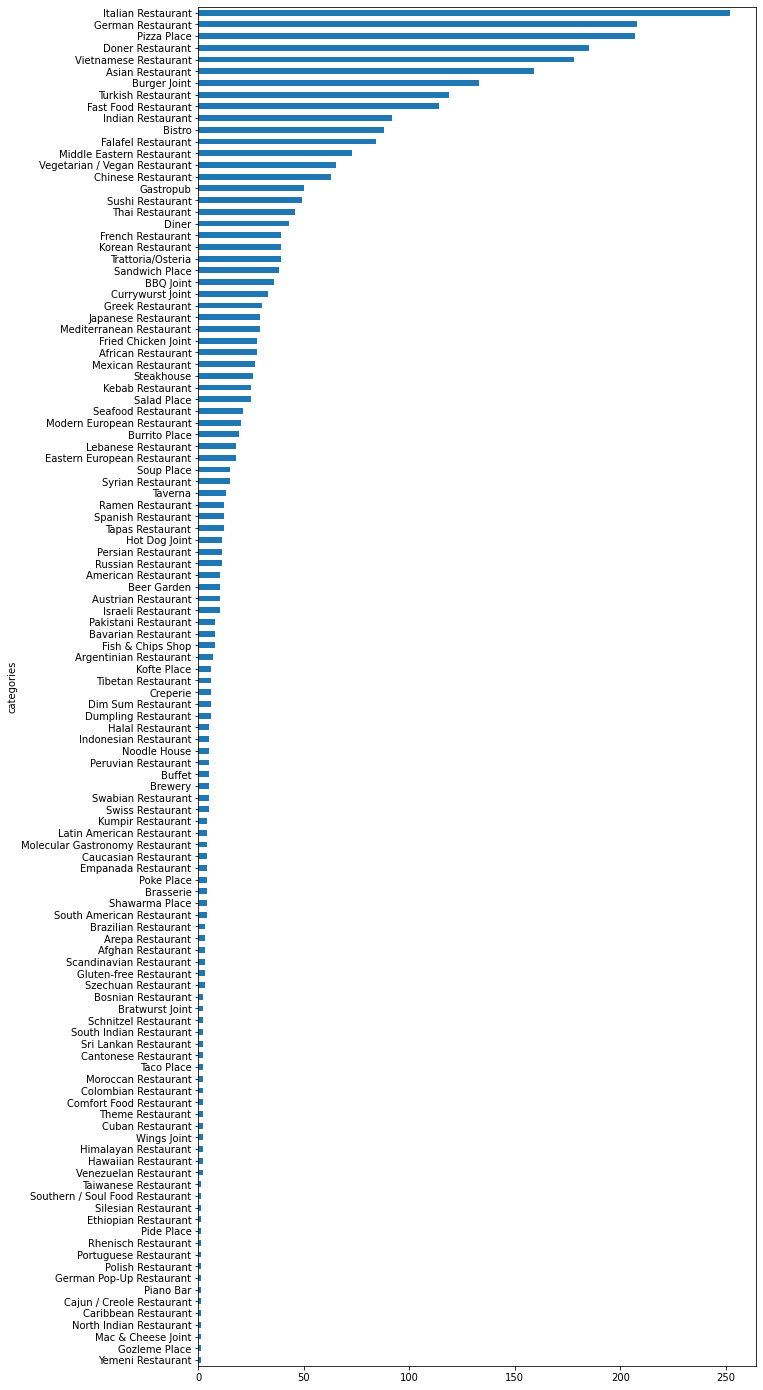

In [26]:
df_full.groupby('categories').size().sort_values().plot.barh(figsize=(10,25))

And how are the venues distrbuted onto our areas? I group the data by spot_id to get the total number of venues per spot.

In [27]:
spots_total_venues = df_full.value_counts(subset=['spot_id', 'spot_lat', 'spot_lon'], sort=False).to_frame(name='venues').reset_index()
spots_total_venues['spot_id'] = spots_total_venues['spot_id'].astype('int64')
spots_total_venues.head()

,spot_id,spot_lat,spot_lon,venues
0,0,52.5655,13.343815,1
1,1,52.5655,13.364503,21
2,2,52.5655,13.385190,8
3,3,52.5655,13.405878,23
4,4,52.5655,13.426566,5


The highest density of venues is 35 in a single area but there are also areas with only a few. As stated above we are looking for the upper end. To get a better idea of the spatial distribution I plot the areas on a map again, this time color codeded by the amount of restaurants in them.

In [29]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_density = folium.Map(location=[mitte_lat, mitte_lon], zoom_start=12)

norm = colors.Normalize(vmin=0, vmax=spots_total_venues['venues'].max())
cmap = cm.get_cmap('YlOrRd')

# add markers to map
for lat, lng, venues in zip(spots_total_venues['spot_lat'], spots_total_venues['spot_lon'], spots_total_venues['venues']):
    my_color = colors.rgb2hex(cmap(norm(venues)))
    label = f"{venues}"
    folium.Circle(
        [lat, lng],
        radius=spot_radius,
        popup=label,
        color='transparent',
        weight=2,
        fill=True,
        fill_color=my_color,
        fill_opacity=0.8,
        parse_html=False).add_to(map_density)
    
map_density

Looks pretty but it's not easy to draw any conclutions from this yet. Since we are explicitly looking for top tier gastronomy areas I'll introduce a threshold before any further steps so we can concentrate on top notch spots. What would be a decent threshold? I'll take a look a the distribution. 

In [32]:
spots_total_venues['venues'].describe(percentiles=[.5, .75, .95])

count    149.000000
mean      21.006711
std        9.834782
min        1.000000
50%       24.000000
75%       29.000000
95%       32.000000
max       35.000000
Name: venues, dtype: float64

Q3 lies at 29, the upper 5% start at 33. Let's introduce this as threshold to filter out the lower 95% of areas. This will give as the four best areas to compare. Let's first look at the map again.

In [37]:
# just the very best areas get passt this
spots_total_venues_high = spots_total_venues[spots_total_venues['venues'] > 33]

In [38]:
# create map
map_density_high = folium.Map(location=[mitte_lat, mitte_lon], zoom_start=12)
norm = colors.Normalize(vmin=25, vmax=spots_total_venues_high['venues'].max())
cmap = cm.get_cmap('YlOrRd')

# add markers to map
for lat, lng, venues, spotid in zip(spots_total_venues_high['spot_lat'], spots_total_venues_high['spot_lon'], spots_total_venues_high['venues'], spots_total_venues_high['spot_id']):
    my_color = colors.rgb2hex(cmap(norm(venues)))
    label = f"ID: {spotid}\nVenues: {venues}"
    folium.Circle(
        [lat, lng],
        radius=spot_radius,
        popup=label,
        color='transparent',
        weight=2,
        fill=True,
        fill_color=my_color,
        fill_opacity=0.6,
        parse_html=False).add_to(map_density_high)
    
map_density_high

Now we have narrowed the data down to an number of spots that can be be analyzed in way more detail. The next step ist to finde out what kinds of restaurants are _uncommon_ in these specific areas. A compilation of a map and some data about the categories in int (and not in it) would be very helpful to our client. I have to write a series of functions to achieve this.

In [39]:
# Get a list of all categories that are NOT in a given area (but at least once in df_full)
def get_cats_not_in_area(spot_id):
    cats_in_area = df_full[df_full.spot_id == spot_id].groupby('categories').size()
    return df_full[~df_full.categories.isin(cats_in_area)].categories.unique()

In [40]:
# with a given location and category return locations and their distance of other venues of the same category
def distances_to_same_cat(lat, lon, category):
    df_same_cat = df_full[['name', 'categories', 'address', 'lat', 'lng']][df_full.categories == category].copy()
    df_same_cat['distance'] = df_same_cat.apply(lambda row : geodesic((lat, lon), (row.lat, row.lng)).km, axis = 1 )
    df_same_cat.drop_duplicates(inplace=True)
    df_same_cat.sort_values(by=['distance'], inplace=True)
    return df_same_cat

In [41]:
# helper function to run distances_to_same_cat() on (spot_lat, spot_lon) by spot_id
def distances_to_cat_by_spot(spot_id, category):
    lat = float(df_spots[df_spots.spot_id == spot_id].lat)
    lon = float(df_spots[df_spots.spot_id == spot_id].lon)
    return distances_to_same_cat(lat, lon, category)

In [42]:
# for a given spot_id return a dataframe with categories that aren't present in in the spot, featuring the smallest distance to the next vanue of that category
def distances_of_nonpresent_cats(spotid):
    result = {'Category':[], 'Shortest Distance':[], 'Avg. Distance':[], 'Amount':[]}
    cats_not_in_area = get_cats_not_in_area(spotid)
    for cat in cats_not_in_area:
        distances = distances_to_cat_by_spot(spotid, cat)
        result['Category'].append(cat)
        result['Shortest Distance'].append(distances.distance.min())
        result['Avg. Distance'].append(distances.distance.mean())
        result['Amount'].append(df_full['categories'][df_full.categories == cat].count())
    df = pd.DataFrame(result)
    df.sort_values(by=['Shortest Distance'], ascending=False, inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

In [43]:
def get_overview_map_html(spotid):
    spot = df_spots[df_spots.spot_id == spotid]
    start_lat = spots_total_venues_high['spot_lat'].mean()
    start_lon = spots_total_venues_high['spot_lon'].mean()
    
    # create map
    over_map = folium.Map(location=[start_lat, start_lon], zoom_start=12)
    norm = colors.Normalize(vmin=25, vmax=spots_total_venues_high['venues'].max())
    cmap = cm.get_cmap('YlOrRd')

    # add markers to map
    for lat, lng, venues, myspotid in zip(spots_total_venues_high['spot_lat'], spots_total_venues_high['spot_lon'], spots_total_venues_high['venues'], spots_total_venues_high['spot_id']):
        my_color = colors.rgb2hex(cmap(norm(venues)))
        label = f"ID: {myspotid}\nVenues: {venues}"
        folium.Circle(
            [lat, lng],
            radius=spot_radius,
            popup=label,
            color='transparent',
            weight=2,
            fill=True,
            fill_color= 'red' if myspotid == spotid else 'grey',
            fill_opacity=0.6,
            parse_html=False).add_to(over_map)

    return over_map._repr_html_()

In [44]:
def get_barchart_html(spotid):
    img = BytesIO()
    fig = df_full[df_full.spot_id == spotid].groupby('categories').size().sort_values().plot.barh(title=f"Venues in Spot {spotid} by category").get_figure()
    fig.savefig(img, format='png', bbox_inches="tight")
    img.seek(0)
    plot_url = base64.b64encode(img.getvalue()).decode('utf8')
    fig.clear()
    return f"<img src='data:image/png;base64, {plot_url}'>"

In [51]:
def display_overview(spotid):
    title = f"Overview for Spot {spotid}"
    map_html = get_overview_map_html(spotid)
    distances_df = distances_of_nonpresent_cats(spotid).head(15).copy()
    df_html = distances_df.to_html().replace('table','table style="display:inline"')
    html_str=f"<h2>{title}</h2>\
    <table><tbody><tr>\
    <td width='60%'>{map_html}</td>\
    <td>{df_html}</td>\
    </tr></tbody></table>\
    <fig width='100%'>{get_barchart_html(spotid)}<fig>"
    display_html(html_str,raw=True)

I'll run these on the area we previously found to be suited for our client's strategy of investing high density, high competition areas.

In [52]:
for spotid in spots_total_venues_high['spot_id']:
    display_overview(spotid)

,Category,Shortest Distance,Avg. Distance,Amount
0,Cajun / Creole Restaurant,9.812888,9.812888,1
1,Venezuelan Restaurant,9.531717,9.586921,2
2,South American Restaurant,8.971761,9.428084,4
3,Taco Place,8.730618,8.730618,2
4,Portuguese Restaurant,8.092994,8.092994,1
5,Caribbean Restaurant,8.005869,8.005869,1
6,Silesian Restaurant,7.781005,7.781005,1
7,Mac & Cheese Joint,7.134290,7.134290,1
8,Moroccan Restaurant,7.131226,7.131226,2
9,Cantonese Restaurant,7.071257,7.705468,2


,Category,Shortest Distance,Avg. Distance,Amount
0,Cajun / Creole Restaurant,8.864151,8.864151,1
1,South American Restaurant,7.247364,7.493090,4
2,Gozleme Place,7.064765,7.064765,1
3,Caribbean Restaurant,6.920378,6.920378,1
4,Venezuelan Restaurant,6.860319,7.107173,2
5,Pide Place,6.849867,6.849867,1
6,Yemeni Restaurant,6.505200,6.505200,1
7,Taco Place,6.317247,6.317247,2
8,Himalayan Restaurant,6.201434,6.201434,2
9,Mac & Cheese Joint,5.772596,5.772596,1


,Category,Shortest Distance,Avg. Distance,Amount
0,Gozleme Place,8.225912,8.225912,1
1,Yemeni Restaurant,7.500651,7.500651,1
2,Cajun / Creole Restaurant,7.445228,7.445228,1
3,Pide Place,7.283960,7.283960,1
4,Halal Restaurant,6.202677,7.227516,5
5,Himalayan Restaurant,5.638975,5.638975,2
6,Caribbean Restaurant,5.597346,5.597346,1
7,South American Restaurant,5.567511,5.705910,4
8,Wings Joint,5.129000,6.301985,2
9,Hawaiian Restaurant,5.108834,5.108834,2


,Category,Shortest Distance,Avg. Distance,Amount
0,Gozleme Place,9.736320,9.736320,1
1,Yemeni Restaurant,8.920628,8.920628,1
2,Pide Place,8.280401,8.280401,1
3,Halal Restaurant,7.417417,8.305867,5
4,Hawaiian Restaurant,6.957212,6.957212,2
5,Wings Joint,6.907672,7.955858,2
6,Cajun / Creole Restaurant,6.454600,6.454600,1
7,Theme Restaurant,6.289800,6.601135,2
8,Bratwurst Joint,6.249989,6.249989,2
9,German Pop-Up Restaurant,6.044577,6.044577,1


<Figure size 432x288 with 0 Axes>

## Discussion
In presentation for our client we could show thise results and offer some discussion for every Spot:

### Spot 67: Moabit
Dominated by Italian, Turkish/Arabic and Vietnamese Restaurants. But from our table we can see that this place doesn't have __Southern or Latino American restaurants__ anywhere near it. So this could be combination to explore further.

### Spot 121: Schöneberg
Many Pizza places but also Turkish and Burgers. It's not to far from Moabit and we have similar results with the __South American Restaurants__ being far of. There are some other intersting candiates on the list like __Gluten-free or Bosnian__.

### Spot 130: Kreuzberg
Many Italian Restaurants but also lots of Burgers and Vietnamese. There are also lot's of diversity from Mexican over Greek to African, you can get it here. Still our result poses some interesting possibilites for something unique. Except for the obligatory Döner/Kebab places there are surprisingly few Turkish/Middle-Eastern places here. The next __Gözleme place__ is over 8km away! Restaurents specializing in __Wings__ or __Hawaiian__ would also be unique for this area.

### Spot 139: Neuköln
This area has many Vietnamese Resaturants but you have to travel quite far to find __Szechuan__ kitchen. Also there again there a some middle easter/turkish options that would be unique here like __Gözleme, Pide or specifically Halal kitchen__

## Conclusion

To actually pick a restaurant location and it takes more. But we saved our client from opening yet another Vietnamese Restaurant in an area where there is one on every corner already. We also were able to give them some ideas for concepts that a customer would have to ride all across town to find.

In a further step it would be interesting to factor rent prices into this analysis.